#### Universidade de Brasília <br> Departamento de Ciência da Computação
# Projeto 1:
### Teoria e Aplicação de Grafos, Turma 01, 2025/1 <br> Prof. Díbio <br> Integrantes do Grupo: Bruno Henrique (221022239), João Victor Prata (202028857), Manuela ()

## Importar Bibliotecas:

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from itertools import combinations

## Coletar Dados:

In [2]:
# Leitura do CSV com pandas
df = pd.read_csv("fake.csv")
# Aqui podemos remover algumas colunas do dataframe que não nos interessam para essa análise com grafos
colunas_desinteressantes = ['uuid', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'main_img_url', 'spam_score', 'type']
df = df.drop(columns=colunas_desinteressantes, axis=1)
# Elementos iniciais do csv
print(df.head())


   ord_in_thread                author                      published  \
0              0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1              0  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2              0     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
3              0                Fed Up  2016-11-01T05:22:00.000+02:00   
4              0                Fed Up  2016-11-01T21:56:00.000+02:00   

                                               title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...   
4  FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...   

                                                text  \
0  Print They should pay all the back all the mon...   
1  Why Did Attorney General Loretta Lynch Plead T...   
2  Red State : \r\nFox News Sunday reported this ...   


## Construir Grafo:

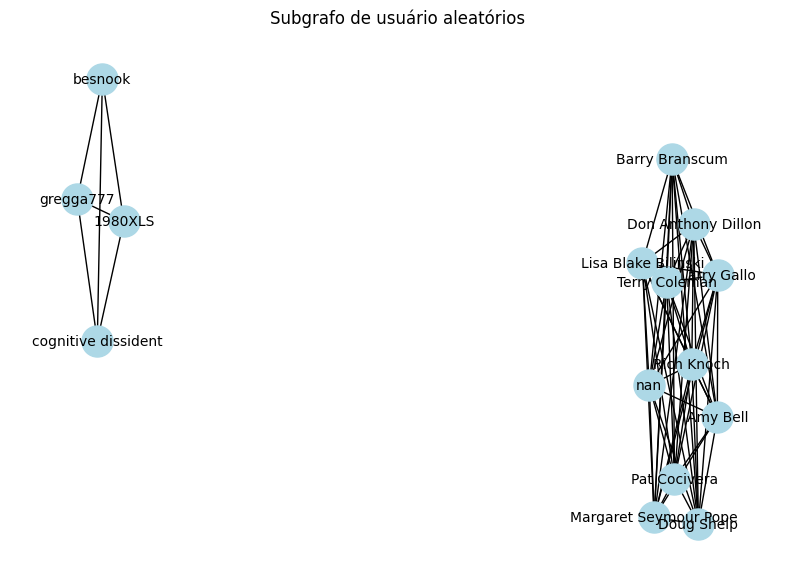

In [12]:
# df.groupby('thread_title') -> Agrupa todo o dataset com base o thread_title
# pode ser descontruído como (thread, grupo) para cada thread presente no dataframe
# Assim, para uma thread x temos todos os autores que estão interagindo sob um tema
G = nx.Graph()
for thread, group in df.groupby('thread_title'):
    autores = group['author'].unique()
    for u1, u2 in combinations(autores, 2):
        if G.has_edge(u1, u2):
            G[u1][u2]['weight'] += 1
        else:
            G.add_edge(u1, u2, weight=1)
# Dado a massividade do grafo armazenado em G, para a visualização dele é melhor compreende-lo com base subgrafos
no_aleatorio = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]
no_aleatorio = [n for n, _ in no_aleatorio]
subG = G.subgraph(no_aleatorio)
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subG)

nx.draw_networkx_nodes(subG, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(subG, pos, width=1)
nx.draw_networkx_labels(subG, pos, font_size=10)

plt.title("Subgrafo de usuário aleatórios")
plt.axis('off')
plt.show()



In [17]:
# Pagerank no Grafo obtido do dataset
# O pagerank implementado pela bib nx é feito com base os parametros:
# pagerank(G: Grafo, alpha: Fator de Amortecimento, max_iter: Maximo de iterações, tol: Tolerância para convergencia)
# Onde, o único parametro obrigatório é o Grafo, todos os outros tem valores default caso não sejam inseridos
pagerank = nx.pagerank(G, alpha=0.85)
# Na variavel tem o retorno da função, que é um dicionário da forma {nó, valor}
# Cada valor é um score associado ao nó
# Dessa forma, temos no retorno do pagerank que o nó com valor mais alto é o nó mais influente no nosso contexto.
print(pagerank) 
maisInfluente = max(pagerank, key=pagerank.get)
print("O mais influente da rede: ", maisInfluente)
print("Score do user mais influente: ", pagerank[maisInfluente])


{nan: 0.0290108030283483, 'b': 0.0006839854842731362, 'tokyowashi (noreply@blogger.com)': 0.0030501611777260717, 'Anonymous': 0.004999899675635758, 'Ken Kurson': 0.00043108923331567175, 'Steve Watson': 0.003336280692147337, 'Daisy Luther': 0.0010885661734298389, 'Editor': 0.004864092287234844, 'Activist Post': 0.005637006848916102, 'hqanon': 0.007992972016760974, 'OZbanislam': 0.0012631252195320238, 'Heather Callaghan': 0.00509899989496343, 'noreply@blogger.com (Alexander Light)': 0.0026188811238740833, 'ecclesiatical': 0.00040334749508737303, 'Enjoykin4': 0.003342596188942329, 'Martin': 0.000783655564832363, 'shorty': 0.008378276125396673, 'Eric Zuesse.': 0.001705348993293901, 'wmw_admin': 0.004465228842387582, 'Pat Buchanan': 0.0005250368252242145, 'PatriotRising': 0.001204723743483105, 'Letsbereal': 0.0006839854842731362, 'Ryan Banister': 0.001117144272949223, 'Madeline': 0.0022926368111681745, 'Kantucky': 0.0009455388818374343, 'Arnold Monteverde (noreply@blogger.com)': 0.001237609